# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Spring 2020

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [1]:
import cv2
import numpy as np
from numpy.linalg import svd, inv
from skimage import draw
import utils
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
def display_images(img_cnt, imgs, titles):
    
    assert img_cnt == len(imgs)
    assert img_cnt == len(titles)
        
    fig, axes = plt.subplots(1,img_cnt, figsize=(25,25))

    for i in range(img_cnt):
        axes[i].imshow(imgs[i],cmap='gray') 
        axes[i].set_title(titles[i], fontsize=15)


In [4]:
# images location
dir_frames = 'images/input/frames/'
dir_output = 'images/output/'

im1_file = dir_frames + 'f0270.jpg'
im2_file = dir_frames + 'f0450.jpg'

# Load an color image in grayscale
im1 = cv2.cvtColor(cv2.imread(im1_file), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(im2_file), cv2.COLOR_BGR2RGB)


In [356]:
def auto_homography(Ia,Ib, homography_func=None,normalization_func=None, debug=True):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0

    H = None
    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 1  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
    
    if(debug):
        print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [6]:
def normalizeCoordinates(pts):
    
    trans = np.zeros((3,3),dtype=float)
    scale = np.zeros((3,3),dtype=float)
    
    std_dev_u = np.ndarray.std(pts[:,0])
    std_dev_v = np.ndarray.std(pts[:,1])
    mean_u = np.mean(pts[:,0])
    mean_v = np.mean(pts[:,1])
    
    trans[0,0] = 1/std_dev_u
    trans[1,1] = 1/std_dev_v
    trans[2,2] = 1
    scale[0,0] = 1 
    scale[0,2] = -mean_u
    scale[1,1] = 1
    scale[1,2] = -mean_v
    scale[2,2] = 1
    
    pts_norm = np.dot((trans * scale), pts)
    
    return pts_norm
    
def computeHomography(pts1, pts2, normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    y, x = pts1.shape
    A = np.zeros((2*x, 9))
    
    for i in range(x):
        k = 2*i 
        A[k][0] = -pts1[0][i]
        A[k][1] = -pts1[1][i]
        A[k][2] = -1
        A[k][6] = pts1[0][i] * pts2[0][i]
        A[k][7] = pts1[1][i] * pts2[0][i]
        A[k][8] = pts2[0][i]
        
        A[k+1][3] = -pts1[0][i]
        A[k+1][4] = -pts1[1][i]
        A[k+1][5] = -1
        A[k+1][6] = pts1[0][i] * pts2[1][i]
        A[k+1][7] = pts1[1][i] * pts2[1][i]
        A[k+1][8] = pts2[1][i]
        
    u, s, vh = np.linalg.svd(A)
    rows, cols = vh.shape
    
    H = vh[:][cols-1].reshape(3,3)
    
    return H


In [7]:
H = auto_homography(im1, im2, computeHomography, normalizeCoordinates)


best score: 165.000000


In [8]:
import matplotlib.pyplot as plt
%matplotlib notebook

def specify_keypoints(img):
    # get mask
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    fig = plt.figure()
    fig.set_label('Draw polygon around source object')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    xs = []
    ys = []
    clicked = []

    def on_mouse_pressed(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)
        plt.plot(x, y, 'r+')

    def onclose(event):
        clicked.append(xs)
        clicked.append(ys)
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    fig.canvas.mpl_connect('close_event', onclose)
    return clicked


If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


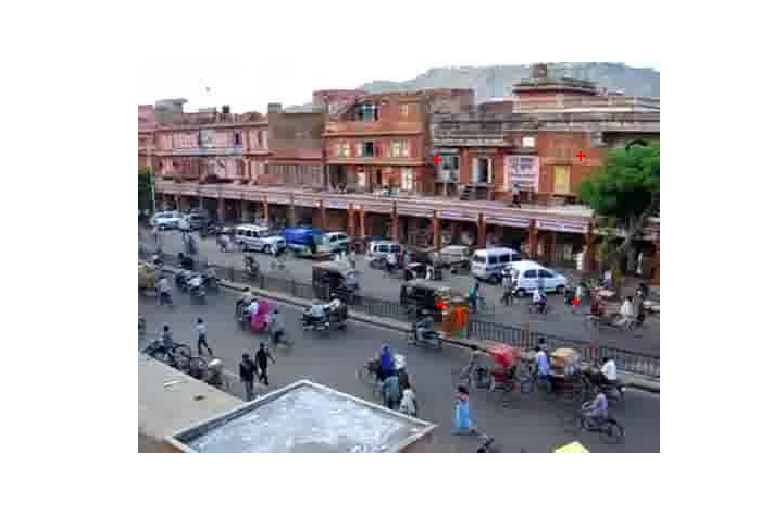

In [9]:
im1_coords = specify_keypoints(im1)

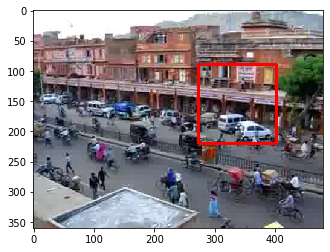

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

start_point = (im1_coords[0][0].astype(int), im1_coords[1][0].astype(int))
end_point = (im1_coords[0][2].astype(int), im1_coords[1][2].astype(int))
img1 = cv2.rectangle(im1,start_point,end_point,(255,0,0),3)
plt.imshow(img1)

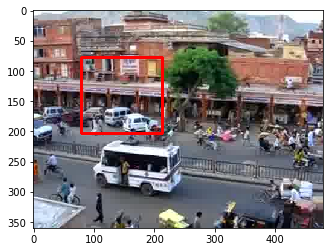

In [11]:
im2_coords = [[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0]]

for i in range(len(im1_coords)):
    x = [0.0,0.0,1.0]
    x[0] = im1_coords[0][i]
    x[1] = im1_coords[1][i]
    x_new = np.dot(H, x)
    
    im2_coords[0][i] = x_new[0]/x_new[2]
    im2_coords[1][i] = x_new[1]/x_new[2]
    im2_coords[2][i] = im2_coords[0][i]
    im2_coords[3][i] = im2_coords[1][i]
       

start_point = (im2_coords[0][0].astype(int), im2_coords[1][0].astype(int))
end_point = (im2_coords[0][2].astype(int), im2_coords[1][2].astype(int))
img2 = cv2.rectangle(im2, start_point,end_point,(255,0,0),3)
plt.imshow(img2)


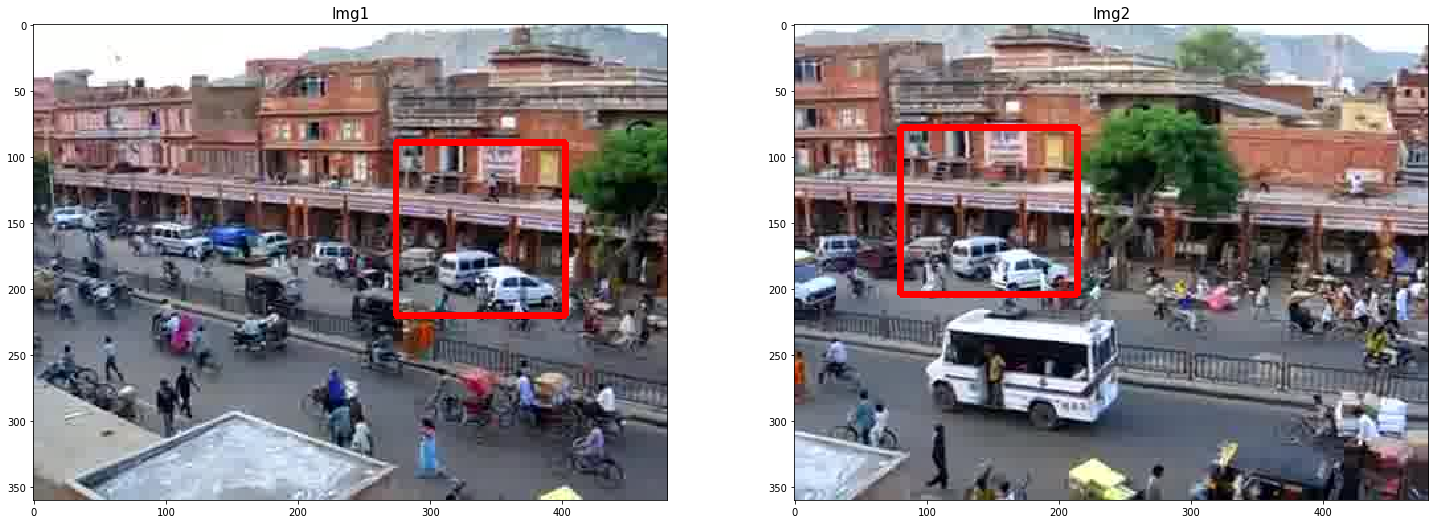

In [12]:
display_images(2, [img1, img2], ['Img1', 'Img2'])

In [13]:
def map_image_to_canvas(im, canvas):
    canvas_1 = np.zeros(canvas.shape, canvas.dtype)
    H,W,C = canvas.shape
    im_h,im_w,im_c = im.shape
    y_start = int(H/2)-int(im_h/2)
    x_start = int(W/2)-int(im_w/2)
 
    for y in range(im_h):
        for x in range(im_w):
            for c in range(im_c):
                canvas_1[y+y_start][x+x_start][c] = im[y][x][c]

    #plt.imshow(canvas_1)
    return canvas_1

In [14]:
def blend(img1, img2, use_utils=False):
    if (use_utils):
        return utils.blendImages(img1, img2)
        
    mask = np.zeros((img1.shape),dtype=int)
    mask = (1-mask) * img2
    mask = np.where(mask==0,0,1)

    blended = (1 - mask)*img1 + img2
    return blended

In [15]:
def write_image(im_path, im):
    bgr_image = (im[:, :, [2, 1, 0]]).astype(np.uint8)
    cv2.imwrite(im_path, bgr_image)


In [16]:
def stitch_images(im1, im2, ref_im=None, canvas=None):
    im1_H, im1_W, im_C = im1.shape

    ## Example usage of cv2.warpPerspective
    projectedWidth = im1_W*3
    projectedHeight = im1_H*2
    
    if (canvas is None):
        canvas = np.zeros((projectedHeight,projectedWidth,3),im1.dtype)
    else:
        projectedHeight, projectedWidth, C = canvas.shape
        
    ref_canvas = None
    if (ref_im is None):
        ref_canvas = map_image_to_canvas(im2, canvas)
    else:
        ref_canvas = map_image_to_canvas(ref_im, canvas)

    sourceHomography = auto_homography(im1, ref_canvas, computeHomography, normalizeCoordinates)
    projectedSource = cv2.warpPerspective(im1, sourceHomography, (projectedWidth, projectedHeight))
    #plt.figure()
    #plt.imshow(projectedSource)
    
    refHomography = auto_homography(im2, ref_canvas, computeHomography, normalizeCoordinates)
    projectedReference = cv2.warpPerspective(im2, refHomography, (projectedWidth, projectedHeight))
    #plt.figure()
    #plt.imshow(projectedReference)
    
    blendedOutput = blend(projectedSource, projectedReference)

    blended_utils  = utils.blendImages(projectedSource, projectedReference)
    #plt.figure()
    #plt.imshow(blended_utils)
    write_image(dir_output + 'merged_part1_utils.jpg', blended_utils)

    return blendedOutput, projectedSource, projectedReference, sourceHomography, refHomography
    

In [17]:
def trim_image(im):
    
    H,W,C = im.shape
    
    last_blank = 0
    
    start_y = -1
    end_y = -1

    im_T = np.transpose(im) # dim = C, W, H
    
    #print('im.shape: ', im.shape, ' im_T.shape: ', im_T.shape)
        
    sum_rows = np.ndarray.sum(im_T[0], axis=0)
    sum_cols = np.ndarray.sum(im_T[0], axis=1)

    sum_rows_1 = np.ndarray.sum(im_T[1], axis=0)
    sum_cols_1 = np.ndarray.sum(im_T[1], axis=1)
    
    sum_rows_2 = np.ndarray.sum(im_T[2], axis=0)
    sum_cols_2 = np.ndarray.sum(im_T[2], axis=1)
    
    #print('sum_rows: ', sum_rows.shape)
    #print('sum_cols: ', sum_cols.shape)

    for y in range(H):
        if (sum_rows[y] == 0 and sum_rows_1[y] == 0 and sum_rows_2[y] == 0):
            if (start_y != -1):
                #print("Blending region startpoint recognised")
                if(last_blank + 1 == y):
                    end_y = y
                    #print("Last non blank row:", y)
                    break
            last_blank = y
        else:
            if (start_y == -1):
                #print("First non blank row:", y)
                start_y = y
        
    if(start_y == -1):
        start_y = 0
    if (end_y == -1):
        end_y = H
       
    #print("start_y: ", start_y, " end_y: ", end_y)  
    
    last_blank = 0
    start_x = -1
    end_x = -1
    
    for x in range(W):
        if (sum_cols[x] == 0 and sum_cols_1[x] == 0 and sum_cols_2[x] == 0):
            if (start_x != -1):
                #print("Blending region startpoint recognised")
                if(last_blank + 1 == x):
                    end_x = x
                    #print("Last non blank col:", x)
                    break
            last_blank = x
        else:
            if (start_x == -1):
                #print("First non blank col:", x)
                start_x = x
        
    if(start_x == -1):
        start_x = 0
    if (end_x == -1):
        end_x = W
        
    #print("start_x: ", start_x, " end_x: ", end_x)
    
    new_h = end_y - start_y + 1
    new_w = end_x - start_x + 1
    
    new_im = np.zeros((new_h, new_w, C), dtype=im.dtype)
    
    #print("New size: ", new_h, " X", new_w, " Shape: ", new_im.shape, " Size: ", new_im.size)
    
    y = start_y
    new_y = 0
    
    while(y < end_y):
        x = start_x
        new_x = 0
        while (x < end_x):
            for c in range(C):
                new_im[new_y][new_x][c] = im[y][x][c]
            x += 1
            new_x += 1
            
        y += 1
        new_y += 1
    
    return new_im

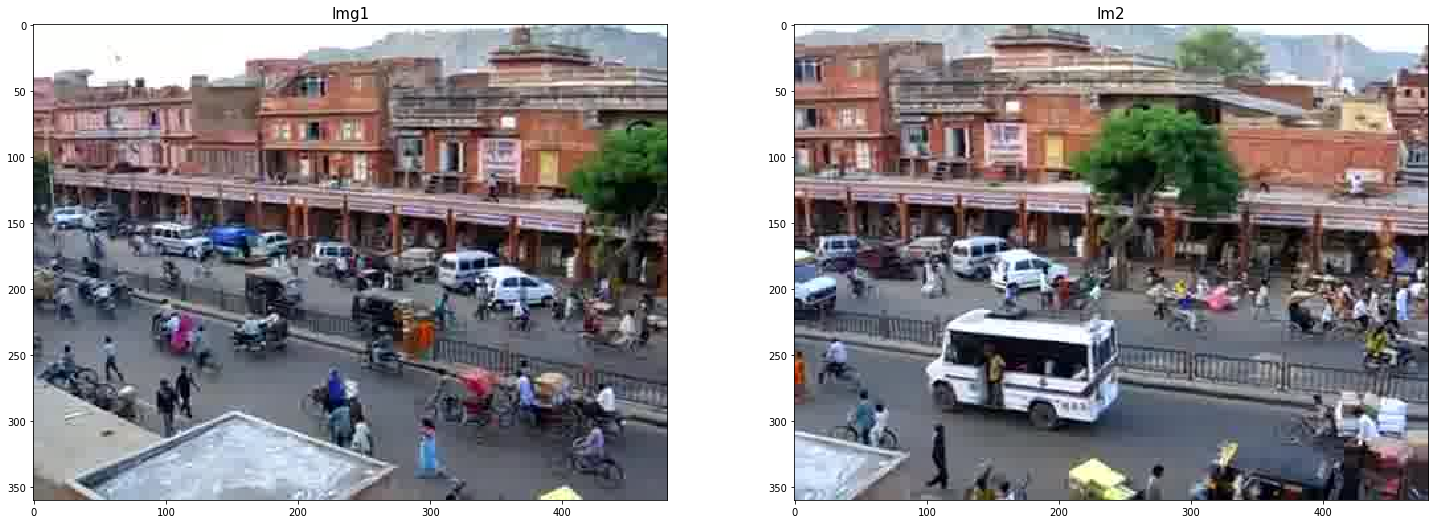

In [18]:
im1 = cv2.cvtColor(cv2.imread(im1_file), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(im2_file), cv2.COLOR_BGR2RGB)
display_images(2, [im1, im2], ['Img1','Im2'])

best score: 161.000000
best score: 2634.000000


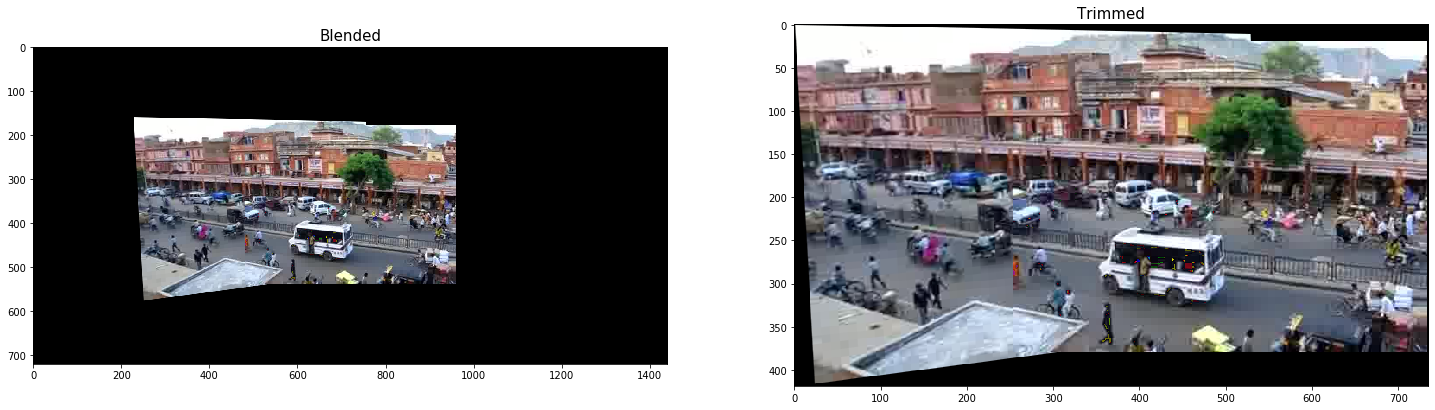

In [19]:
blended, projectedSource, projectedReference, sourceHomography, refHomography = stitch_images(im1, im2)
blended_trimmed = trim_image(blended)

display_images(2, [blended, blended_trimmed], ['Blended','Trimmed'])

write_image(dir_output + 'merged_part1.jpg', blended_trimmed)

### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



In [20]:
import cv2
import numpy as np

In [21]:
master_frames =[90, 270, 450, 630, 810]
reference_frame = 450
reference_idx = master_frames.index(reference_frame)

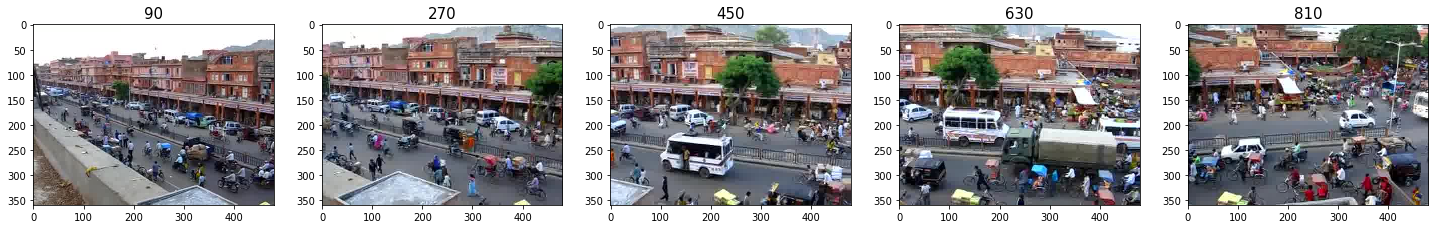

In [22]:
dir_frames = 'images/input/frames/'
dir_output = 'images/output/'

im_frames = []
reference_im  = None

for idx in master_frames:
    im_file = 'f' + '{:04d}'.format(idx) + '.jpg'
    im = cv2.cvtColor(cv2.imread(dir_frames + im_file), cv2.COLOR_BGR2RGB)
    im_frames.append(im)
    if (reference_idx == idx):
        reference_im = im
    
display_images(len(master_frames), im_frames, master_frames)

In [24]:
def stitch_images_bulk(images, reference_im):
    img_cnt = len(images)
    
    assert img_cnt > 0
    
    idx = 0
    prev = None
    blended_frames = []
    
    im_H, im_W, im_C = images[0].shape
    
    canvas_H = im_H * 3
    canvas_W = im_W * (img_cnt + 1)
    
    canvas = np.zeros((canvas_H, canvas_W, im_C), dtype=images[0].dtype)
    blendedOutput = canvas
    
    canvas = map_image_to_canvas(reference_im, canvas)
   
    
    while idx < img_cnt:
        if (prev is None):
            im1 = images[idx]
            im2 = images[idx+1]
        else:
            im1 = prev
            im2 = images[idx]
            
        blended, projectedSrc, projectedRef, srcHomography, refHomography = stitch_images(im1, im2, reference_im, canvas)
        #blended_trimmed = trim_image(blended)
        
        blended_frames.append(blended)
        blendedOutput = blend(blendedOutput, blended, True)
        
        prev = im2
        
        plt.figure()
        #display_images(4, [im1, im2, blended, blendedOutput],['1','2','Blended','Multiple'])

        print('idx: ' , idx, ' blended shape: ' , prev.shape, ' dtype: ', prev.dtype)
    
        idx += 1

    blendedOutput = trim_image(blendedOutput)
    
    return blendedOutput


best score: 63.000000
best score: 158.000000
idx:  0  blended shape:  (360, 480, 3)  dtype:  uint8
best score: 160.000000
best score: 161.000000
idx:  1  blended shape:  (360, 480, 3)  dtype:  uint8
best score: 159.000000
best score: 2634.000000
idx:  2  blended shape:  (360, 480, 3)  dtype:  uint8
best score: 2634.000000
best score: 125.000000
idx:  3  blended shape:  (360, 480, 3)  dtype:  uint8
best score: 129.000000
best score: 52.000000
idx:  4  blended shape:  (360, 480, 3)  dtype:  uint8


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

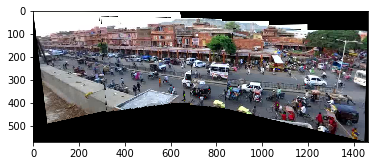

In [25]:
panorama = stitch_images_bulk(im_frames, im_frames[2])
plt.imshow(panorama)
write_image(dir_output + 'panorama_5_frames.jpg', panorama)

### Part 3: Map the video to the reference plane

In [382]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from datetime import datetime

In [383]:
dir_frames = 'images/input/frames/'
dir_output = 'images/output/'

filenames = []
filesinfo = os.scandir(dir_frames)

In [384]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))


In [985]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.uint8)


In [986]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB)

In [987]:
def projectFrame(im, reference_im):
    
    canvasHeight, canvasWidth, canvasChannels = reference_im.shape
    
    sourceHomography = auto_homography(im, reference_im, computeHomography, normalizeCoordinates, False)
        
    projectedSource = cv2.warpPerspective(im, sourceHomography, (canvasWidth, canvasHeight))
    
    return sourceHomography, projectedSource

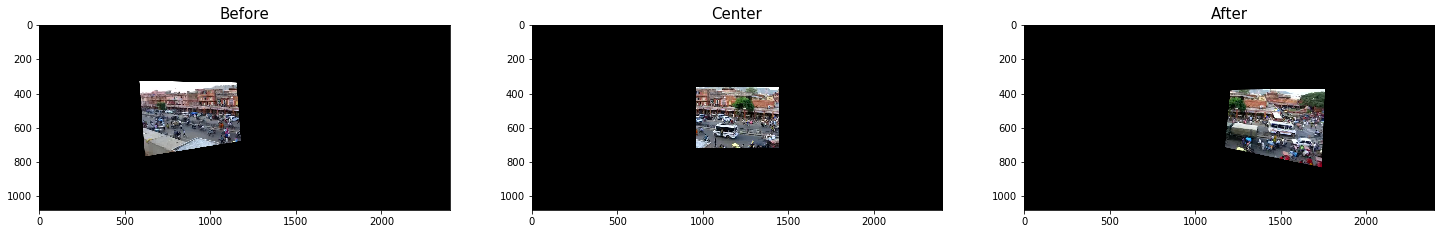

In [1012]:
frameCount = 900

ref_im_before = frames[200]
ref_im_center = frames[450]
ref_im_after = frames[700]

canvas_H = frameHeight * 3
canvas_W = frameWidth * 5
canvas = np.zeros((canvas_H, canvas_W, 3), dtype=frames[0].dtype)

ref_canvas_center = map_image_to_canvas(ref_im_center, canvas)

framesProjection = np.zeros((frameCount,canvas_H,canvas_W,3),dtype=frames[0].dtype)
framesHomography = np.zeros((frameCount,3,3),dtype=frames[0].dtype)

ref_H_before = auto_homography(ref_im_before, ref_canvas_center, computeHomography, normalizeCoordinates, False)
ref_canvas_before = cv2.warpPerspective(ref_im_before, ref_H_before, (canvas_W, canvas_H))

ref_H_after = auto_homography(ref_im_after, ref_canvas_center, computeHomography, normalizeCoordinates, False)
ref_canvas_after = cv2.warpPerspective(ref_im_after, ref_H_after, (canvas_W, canvas_H))

display_images(3, [ref_canvas_before, ref_canvas_center,ref_canvas_after],['Before','Center','After'])

In [1014]:
print(datetime.now(), ' Generating frame projections')

projection_dir = dir_output + '/projection/'
start_time = datetime.now()

for idx in range(frameCount):
    #print('Projecting frame ', str(idx))
    
    filename = 'fnew' + '{:04d}'.format(idx+1)
    ref_canvas = ref_canvas_center
    
    if (idx < 90):
        ref_canvas = ref_canvas_before
    elif (idx > 810):
        ref_canvas = ref_canvas_after
        
    homography, projection = projectFrame(frames[idx], ref_canvas)
    
    framesProjection[idx] = projection
    framesHomography[idx] = homography
    
    titles.append(filename)
    
    im_path = projection_dir + filename + '.jpg'
    
    if (os.path.exists(im_path)):
        os.remove(im_path)
    write_image(im_path, projection)
        
    percent = idx/frameCount*100
    if(percent > 1 and percent % 5 == 0):
        print(datetime.now(), ' Progress :', '{:.2f}%'.format(percent), ' Elapse time: ', (datetime.now() - start_time))
    
        

2020-04-27 02:15:59.393558  Generating frame projections
2020-04-27 02:17:28.057009  Progress : 5.00%  Elapse time:  0:01:28.663044
2020-04-27 02:18:58.119821  Progress : 10.00%  Elapse time:  0:02:58.725856
2020-04-27 02:20:00.657643  Progress : 15.00%  Elapse time:  0:04:01.263678
2020-04-27 02:21:05.358019  Progress : 20.00%  Elapse time:  0:05:05.964053
2020-04-27 02:22:15.975634  Progress : 25.00%  Elapse time:  0:06:16.581668
2020-04-27 02:23:31.131328  Progress : 30.00%  Elapse time:  0:07:31.737362
2020-04-27 02:24:50.372426  Progress : 35.00%  Elapse time:  0:08:50.978461
2020-04-27 02:26:14.970675  Progress : 40.00%  Elapse time:  0:10:15.576709
2020-04-27 02:34:08.086367  Progress : 45.00%  Elapse time:  0:18:08.692427
2020-04-27 02:40:18.365164  Progress : 50.00%  Elapse time:  0:24:18.971199
2020-04-27 02:48:53.008792  Progress : 60.00%  Elapse time:  0:32:53.614826
2020-04-27 02:50:15.102613  Progress : 65.00%  Elapse time:  0:34:15.708648
2020-04-27 02:51:34.696581  Prog

In [1015]:
video_file=dir_output + 'video-part3.mpeg'

if(os.path.exists(video_file)):
    os.remove(video_file)
utils.imageFolder2mpeg(projection_dir, video_file, fps=30)


### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

In [362]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [363]:
dir_input = 'images/output/projection/'
dir_output = 'images/output/'

In [364]:
filesinfo = os.scandir(dir_input)
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))


In [365]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
framesProjection = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.uint8)


In [366]:
for idx, file_i in enumerate(filenames):
    framesProjection[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB)


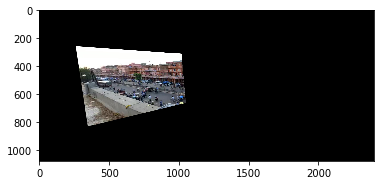

In [367]:
plt.imshow(framesProjection[0])

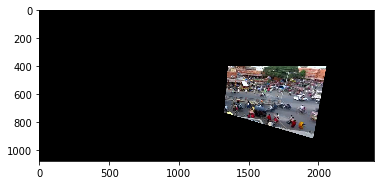

In [368]:
plt.imshow(framesProjection[frameCount-1])

In [369]:
H,W,C = framesProjection[0].shape

background_im_mean = np.zeros(framesProjection[0].shape, framesProjection[0].dtype)
background_im_median = np.zeros(framesProjection[0].shape, framesProjection[0].dtype)

frames_T = np.transpose(framesProjection)

print('frames.shape: ', framesProjection.shape, ' frames_T.shape: ', frames_T.shape)

frames.shape:  (902, 1080, 2400, 3)  frames_T.shape:  (3, 2400, 1080, 902)


In [374]:
progress = 0

start_time = datetime.now()

print(datetime.now(), ' Generating background image')
last = False
pixel_cnt = 0

for y in range(H):
    for x in range(W):
        for c in range(C):
            if (np.sum(frames_T[c][x][y]) > 0):
                
                extracted = np.extract(frames_T[c][x][y] > 0, frames_T[c][x][y])
                
                mean_value = np.mean(extracted).astype(np.uint8)    
                median_value = np.median(extracted).astype(np.uint8)
            
                background_im_mean[y][x][c] = mean_value
                background_im_median[y][x][c] = median_value
            
    
    percent = y/H*100
    if((percent > 1 and percent % 5 == 0) or y == H-1):
        elapsed = datetime.now() - start_time
        print(str(datetime.now()) + ' Progress :', '{:.0f}%'.format(percent) + ' Elapse time: ' + str(elapsed))

elapsed = datetime.now() - start_time
print(str(datetime.now()),' Completed background image. Elapse time: ' + str(elapsed))


2020-04-26 11:51:04.562433  Generating background image
2020-04-26 11:51:15.087547 Progress : 5% Elapse time: 0:00:10.525166
2020-04-26 11:51:25.604558 Progress : 10% Elapse time: 0:00:21.042177
2020-04-26 11:51:36.081468 Progress : 15% Elapse time: 0:00:31.519078
2020-04-26 11:51:47.330330 Progress : 20% Elapse time: 0:00:42.767949
2020-04-26 11:51:58.323608 Progress : 25% Elapse time: 0:00:53.761226
2020-04-26 11:52:17.899926 Progress : 30% Elapse time: 0:01:13.337545
2020-04-26 11:52:46.152865 Progress : 35% Elapse time: 0:01:41.590483
2020-04-26 11:53:24.201155 Progress : 40% Elapse time: 0:02:19.638773
2020-04-26 11:54:02.534814 Progress : 45% Elapse time: 0:02:57.972433
2020-04-26 11:54:40.404878 Progress : 50% Elapse time: 0:03:35.842497
2020-04-26 11:55:55.349068 Progress : 60% Elapse time: 0:04:50.786685
2020-04-26 11:56:32.326619 Progress : 65% Elapse time: 0:05:27.764238
2020-04-26 11:57:09.340013 Progress : 70% Elapse time: 0:06:04.777632
2020-04-26 11:57:37.103635 Progress

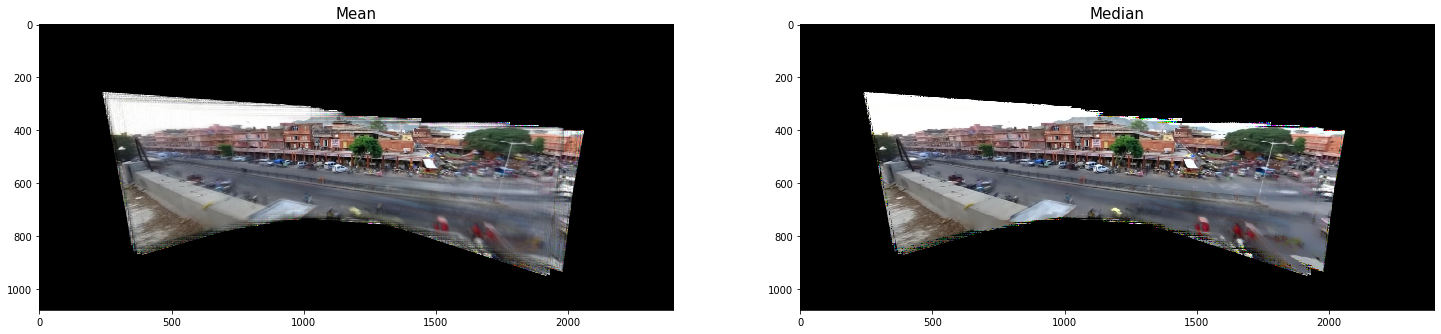

In [375]:
display_images(2, [background_im_mean, background_im_median],['Mean','Median'])


In [376]:
background_im_mean_path =  dir_output + 'background_mean.jpg'
background_im_median_path =  dir_output + 'background_median.jpg'

write_image(background_im_mean_path, trim_image(background_im_mean))
write_image(background_im_median_path, trim_image(background_im_median))


### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [434]:
import os
import cv2
import numpy as np

In [518]:
dir_input = 'images/output/projection/'
dir_output = 'images/output/'

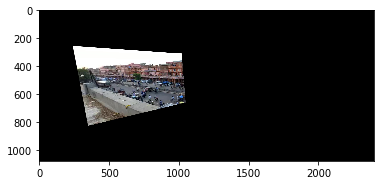

In [519]:
filesinfo = os.scandir(dir_input)
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

im = cv2.cvtColor(cv2.imread(filenames[0]), cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [521]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
projectedFrames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.uint8)

for idx, file_i in enumerate(filenames):
    projectedFrames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB)
    

In [535]:
def generate_bg_video(background_im, projected_frames, target_frame, output_dir, video_bg_file ):

    frameCount = len(projected_frames)
    
    bg_H, bg_W, bg_C = background_im.shape
    frame_H,frame_W,C = target_frame.shape
    
    for idx in range(frameCount):
        projection = projected_frames[idx]
        
        homography = framesHomography[idx]
        homography_inv = inv(homography)
        
        mask = np.where(projection > 0, 1, 0)
        bg_frame = (background_im * mask).astype(np.uint8)

        bg_frame_remapped = cv2.warpPerspective(bg_frame, homography_inv, (frame_W, frame_H))
        
        #display_images(3, [im, trim_image(bg_frame), bg_frame_remapped],['Orig', 'BG', 'Remapped'])
        
        bg_frame_path = output_dir + 'f_bg_' + '{:04d}'.format(idx) + '.jpg'
        
        if(os.path.exists(bg_frame_path)):
            os.remove(bg_frame_path)
        write_image(bg_frame_path, bg_frame_remapped)
        
        if (idx % 50 == 0):
            print(datetime.now(),' Completed processing till frame ', str(idx+1))


    if(os.path.exists(video_bg_file)):
        os.remove(video_bg_file)
        
    print(datetime.now(),' Generating Video')
    utils.imageFolder2mpeg(output_dir, video_bg_file, fps=30)
    print(datetime.now(), ' Done')
    

In [536]:
projection_bg_median_dir = dir_output + '/projection_bg_median/'
video_bg_median_file = dir_output + 'video-part5-bg-median.mpeg'
target_frame = cv2.cvtColor(cv2.imread('images/input/frames/f0001.jpg'), cv2.COLOR_BGR2RGB)

generate_bg_video(background_im_median, projectedFrames, target_frame, projection_bg_median_dir, video_bg_median_file)


2020-04-26 15:55:11.289061  Completed processing till frame  1
2020-04-26 15:55:13.962290  Completed processing till frame  51
2020-04-26 15:55:16.521606  Completed processing till frame  101
2020-04-26 15:55:18.867826  Completed processing till frame  151
2020-04-26 15:55:21.210767  Completed processing till frame  201
2020-04-26 15:55:23.542296  Completed processing till frame  251
2020-04-26 15:55:25.870672  Completed processing till frame  301
2020-04-26 15:55:28.195184  Completed processing till frame  351
2020-04-26 15:55:30.522967  Completed processing till frame  401
2020-04-26 15:55:32.843802  Completed processing till frame  451
2020-04-26 15:55:35.633730  Completed processing till frame  501
2020-04-26 15:55:38.343199  Completed processing till frame  551
2020-04-26 15:55:40.892186  Completed processing till frame  601
2020-04-26 15:55:43.303038  Completed processing till frame  651
2020-04-26 15:55:45.756039  Completed processing till frame  701
2020-04-26 15:55:48.629269  

In [538]:
projection_bg_mean_dir = dir_output + '/projection_bg_mean/'
video_bg_mean_file = dir_output + 'video-part5-bg-mean.mpeg'
generate_bg_video(background_im_mean, projectedFrames, target_frame, projection_bg_mean_dir, video_bg_mean_file)


2020-04-26 16:01:13.846771  Completed processing till frame  1
2020-04-26 16:01:16.547491  Completed processing till frame  51
2020-04-26 16:01:18.979074  Completed processing till frame  101
2020-04-26 16:01:21.335246  Completed processing till frame  151
2020-04-26 16:01:23.963411  Completed processing till frame  201
2020-04-26 16:01:26.898888  Completed processing till frame  251
2020-04-26 16:01:29.697122  Completed processing till frame  301
2020-04-26 16:01:32.202148  Completed processing till frame  351
2020-04-26 16:01:34.545967  Completed processing till frame  401
2020-04-26 16:01:36.885704  Completed processing till frame  451
2020-04-26 16:01:39.240093  Completed processing till frame  501
2020-04-26 16:01:41.787841  Completed processing till frame  551
2020-04-26 16:01:44.752412  Completed processing till frame  601
2020-04-26 16:01:47.535830  Completed processing till frame  651
2020-04-26 16:01:50.068198  Completed processing till frame  701
2020-04-26 16:01:52.691408  

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [539]:
import os
import cv2
import numpy as np

In [540]:
dir_input = 'images/input/frames/'
dir_output = 'images/output/'

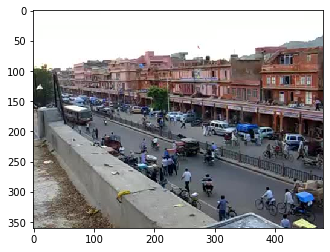

In [541]:
filesinfo = os.scandir(dir_input)
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

im = cv2.cvtColor(cv2.imread(filenames[0]), cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [552]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.uint8)

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB)
    

In [946]:
def resize_image(im, new_size):
    
    im_r, im_g, im_b = cv2.split(im)
    
    im_r_resized = cv2.resize(im_r, new_size)
    im_g_resized = cv2.resize(im_g, new_size)
    im_b_resized = cv2.resize(im_b, new_size)
    
    im_resized = cv2.merge((im_r_resized, im_g_resized, im_b_resized))
    
    return im_resized

def apply_gaussian_filter(im, size, sigma):
    low_pass_filtered = cv2.GaussianBlur(im, (size, size), sigma)

    return low_pass_filtered

def laplacian_filter(im, size, sigma):
    
    low_pass_filtered = apply_gaussian_filter(im, size, sigma)
    high_pass_filtered = np.subtract(im, low_pass_filtered)
    
    return high_pass_filtered

def apply_laplacian_filter(im, size, sigma):
    laplacian_filtered = np.zeros(im.shape, im.dtype)
    
    if(len(im.shape) > 2):
        im_r, im_g, im_b = cv2.split(im)
        filtered = np.zeros((3,im.shape[0],im.shape[1]), im.dtype)
        
        filtered[0] = laplacian_filter(im_r, size, sigma)
        filtered[1] = laplacian_filter(im_g, size, sigma)
        filtered[2] = laplacian_filter(im_b, size, sigma)
        laplacian_filtered = cv2.merge((filtered[0],filtered[1],filtered[2]))
    else:
        laplacian_filtered = laplacian_filter(im, size, sigma)
    
    #display_images(2, [im, laplacian_filtered], ['Original', 'High pass filtered'],['double','double'])
    
    return laplacian_filtered

In [972]:
def generate_fg_video(background_im, input_frames, target_frame, output_dir, video_file ):

    frameCount = len(input_frames)
    
    bg_H, bg_W, bg_C = background_im.shape
    frame_H, frame_W, C = target_frame.shape
    
    threshold = 25
    bins = range(0, 256)
    
    most_freq_vals = np.zeros((256,3), dtype=int)
    background_im_T = background_im.transpose()
    
    matrix = np.zeros((256, 3), dtype=int)
    
    for c in range(bg_C):
        hist = np.histogram(background_im_T[c], bins)
        rev_sorted = np.flip(np.sort(hist[0]))
        
        for idx in range(125):
            value = rev_sorted[idx]
            index = np.where(hist[0] == value)
            pixel_value = hist[1][index[0][0]]
            most_freq_vals[pixel_value][c] = 1
                
    for idx in range(frameCount):
        frame = input_frames[idx]
        
        homography = framesHomography[idx]
        homography_inv = inv(homography)
        
        projection = framesProjection[idx]
        bg_mask = np.where(projection > 0, 1, 0)
        projection_bg = (background_im * bg_mask).astype(frame.dtype)

        bg_frame = cv2.warpPerspective(projection_bg, homography_inv, (frame_W, frame_H))
    
        bg_frame_gaussian = apply_gaussian_filter(bg_frame, 5, 25)
        frame_gaussian = apply_gaussian_filter(frame, 5, 25)
        
        diff_of_gaussian = bg_frame_gaussian - frame_gaussian
        
        #print('Min:', diff_of_gaussian.min(), ' Max: ', diff_of_gaussian.max())

        fg_mask = np.where(abs(diff_of_gaussian) > threshold, 1, 0)
        fg_frame = (frame * fg_mask).astype(frame.dtype)

        fg_frame_new = np.ones(frame.shape, frame.dtype) * 75
        
        for x in range(frame_W):
            for y in range(frame_H):
                skip_count = 0
                for c in range(3):
                    pixel_val = fg_frame[y][x][c]
                    if(most_freq_vals[pixel_val][c] == 1):  
                        skip_count += 1
                        continue
                        
                if (skip_count < 3): 
                    fg_frame_new[y][x] = fg_frame[y][x]
                         
        #display_images(5, [frame, diff_of_gaussian, bg_frame, fg_frame, fg_frame_new ],['Orig', 'Diff', 'BG', 'FG', 'New'])
        
        #continue
        
        fg_frame_path = output_dir + 'f_fg_' + '{:04d}'.format(idx) + '.jpg'
        
        if(os.path.exists(fg_frame_path)):
            os.remove(fg_frame_path)
        write_image(fg_frame_path, fg_frame_new)
        
        if (idx % 50 == 0):
            print(datetime.now(),' Completed processing till frame ', str(idx+1))

    #return


    if(os.path.exists(video_file)):
        os.remove(video_file)
        
    print(datetime.now(),' Generating Video')
    utils.imageFolder2mpeg(output_dir, video_file, fps=30)
    print(datetime.now(), ' Done')
    

In [973]:
projection_fg_dir = dir_output + '/projection_fg/'
video_fg_file = dir_output + 'video-part6-fg.mpeg'
target_frame = frames[0]

#utils.imageFolder2mpeg(projection_fg_dir, video_fg_file, fps=30)
    
generate_fg_video(background_im_mean, frames, target_frame, projection_fg_dir, video_fg_file)


2020-04-26 20:53:32.344294  Completed processing till frame  1
2020-04-26 20:54:15.085371  Completed processing till frame  51
2020-04-26 20:54:55.129751  Completed processing till frame  101
2020-04-26 20:55:35.144079  Completed processing till frame  151
2020-04-26 20:56:15.604686  Completed processing till frame  201
2020-04-26 20:56:55.748685  Completed processing till frame  251
2020-04-26 20:57:36.023003  Completed processing till frame  301
2020-04-26 20:58:16.620693  Completed processing till frame  351
2020-04-26 20:58:57.407446  Completed processing till frame  401
2020-04-26 20:59:38.351097  Completed processing till frame  451
2020-04-26 21:00:18.837193  Completed processing till frame  501
2020-04-26 21:00:59.330037  Completed processing till frame  551
2020-04-26 21:01:40.272842  Completed processing till frame  601
2020-04-26 21:02:21.756761  Completed processing till frame  651
2020-04-26 21:03:03.153744  Completed processing till frame  701
2020-04-26 21:03:43.801330  

## Bells and whistles